# from scratch to charts
*desde la concepción de una obra al éxito en plataformas digitales*

## Abstract

La industria musical enfrenta desde su génesis el desafío de predecir qué canciones resonarán con el público. Siendo que la estructura de una canción juega un papel fundamental en su percepción por parte del oyente, este proyecto busca explorar si existe una correlación entre las características propias de la morfología de una obra musical y su popularidad en plataformas digitales.

En este sentido, Spotify se ha convertido en el estándar de facto para el consumo de música en streaming, influyendo en la forma en que descubrimos, escuchamos y compartimos música. Al analizar los datos que proporciona Spotify desde su API, podemos obtener una visión muy precisa de lo que es popular en la música y cómo evolucionan las tendencias a lo largo del tiempo.

A través del análisis de datos se identificarán patrones en características tales como la duración, sonoridad, tempo, tonalidad y estructura que podrían predecir el éxito de una canción.
Utilizando técnicas de machine learning, se desarrollará un modelo capaz de relacionar el éxito de una canción en función de su composición musical.





---



### Motivación
Las primeras preguntas que se suscitan y originan este estudio son:
* ¿Cómo interactúan diferentes variables (por ejemplo, tempo y tonalidad) para influir en la popularidad?
* ¿Cuáles son las características acústicas y estructurales que más influyen en la popularidad de una canción en Spotify?
* Siendo que el orden en el que se ditribuyen las canciones en un álbum pueden obedecer tanto criterios estético-conceptuales como también deciciones de mercado, ¿Existe una relación entre la posición de una canción dentro de un álbum y su nivel de popularidad?
* ¿Existen diferencias significativas en la popularidad entre las canciones en modo mayor y menor?
* ¿Cuál es el rango de tempo ideal para lograr una mayor popularidad en diferentes géneros musicales?
* ¿Cuál es el número óptimo de segmentos por canción para maximizar la atención del oyente?
¿Cómo afecta el uso de fade-out a la percepción y popularidad de una canción? ¿Existe una duración "sana" de este recurso?
* ¿Cómo han evolucionado las preferencias de los oyentes a lo largo del tiempo?
* ¿Existen diferencias culturales en las preferencias musicales?

Y tal vez la más importante, la que todo artista teme saber y todo productor anhela responder:
* **¿Existe una combinación ideal de características que maximice la popularidad?**

### Hipótesis específicas

* Las canciones con un tempo medio tienden a ser más populares que aquellas de ritmos muy rápidos o muy lentos.

* Las canciones en tonalidades mayores son percibidas como más alegres y positivas, lo que podría correlacionarse con una mayor popularidad.

* Las canciones con un número óptimo de segmentos (ni demasiados ni muy pocos) son más atractivas para los oyentes.

* Las canciones que ocupan las primeras o últimas posiciones en un álbum tienen mayores probabilidades de ser escuchadas y, por lo tanto, de ser más populares.

* El uso de fade out como artificio barato y poco expresivo es una simplificación excesivamente fácil de terminar una canción sin ningún tipo de esfuerzo creativo. Esta técnica se ha vuelto un recurso tan común que ha llevado a una homogeneización del sonido, carente de originalidad, privando al oyente de una conclusión satisfactoria y memorable.
Por este motivo hay un público sensible que se siente atraido por obras que concluyan con un decrescendo natural y bien resuelto, propio de la instrumentación.


### Audiencia

Los resultados de este estudio pretenden servir como guía para músicos y productores al momento de crear y lanzar su producción, aportando nuevas perspectivas sobre la relación entre la forma y el contenido en la música popular.

## Data Acquisition

Para la elaboración del set de datos que compone este análisis, su utilizan las herramientas para desarrolladores que ofrece Spotify a través de su web API:
https://developer.spotify.com/documentation/web-api

Para obtener un limite de consultas diarias más alto se utilizó la librería Spotipy: https://spotipy.readthedocs.io/

In [ ]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 9.2 MB/s eta 0:00:00


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
import pandas as pd
import numpy as np
from requests import post, get
import json
import base64
import glob
import time

#### Autenticación en Spotify Web API

In [ ]:
# Credenciales de la API de Spotify (reemplaza con tus propias credenciales)
client_id = 'f98159d9663c491592e2740feb54028d'
client_secret = '5e771a389c1847c3b9af400dac65667d'

# Autenticación de Spotipy
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
# clave completa para hacerla esclable
def get_auth_header(token):
    return{"Authorization": "Bearer " + token}

In [ ]:
# solicitar clave de acceso a spotify
def get_token():
  auth_string = client_id + ":" + client_secret
  auth_bytes = auth_string.encode("utf-8")
  auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
  # llamar al servicio de autentificación de spotify
  url = "https://accounts.spotify.com/api/token"
  headers = {
      "Authorization": "Basic " + auth_base64,
       "Content-Type": "application/x-www-form-urlencoded"

   }
  data = {"grant_type": "client_credentials"}
  result = post(url, headers = headers, data = data)
  json_result = json.loads(result.content)
  token = json_result["access_token"]
  return token

In [ ]:
token = get_token()

El porceso de extracción se planificó en tres partes:


1. Crear lista de géneros musicales disponibles en Spotify
2. Crear listas de 50 tracks (límite máximo de enpoint [api.spotify.com/v1/search](https://developer.spotify.com/documentation/web-api/reference/search) ) de cada género musical y año de lanzamiento.
3. Obtener información de catálogo de esos tracks a través del endpoint [api.spotify.com/v1/tracks](https://developer.spotify.com/documentation/web-api/reference/get-several-tracks)
4. Obtener un análisis de audio de bajo nivel de una pista del catálogo via [api.spotify.com/v1/audio-analysis/{id}](https://developer.spotify.com/documentation/web-api/reference/get-audio-analysis)

#### 50_spotify_tracks_by_year_and_genre

In [ ]:
# Crear lista de generos
def get_generos():
  generos = sp.recommendation_genre_seeds()['genres']
  return generos

In [ ]:
generos_list = get_generos()

Así se obtiene una lista de los **126 géneros musicales** disponibles para recomendaciones .

In [ ]:
len(generos_list)

126

In [ ]:
# Crear lista de años desde comienzo del Siglo XX a la actualidad.
y_list = list(range(1990, 2025))

Función para buscar tracks por Género & Año de lanzamiento

In [ ]:
# Función para buscar canciones por genero y año
def search_for_tracks_by_genre_year(genero, ano):
    resultados = sp.search(q=f'genre:{genero} year:{ano}', type='track', limit = 50)
    tracks = resultados['tracks']['items']

    data = []
    for track in tracks:
        artistas = track['artists']
        artistas_nombres = [artista['name'] for artista in artistas]

        data.append({
            'artista': ', '.join(artistas_nombres),
            'album': track['album']['name'],
            'cancion': track['name'],
            'id_track': track['id'],
            'fecha_lanzamiento': track['album']['release_date'],
            'genero': genero
        })

    return data

Así, a aprtir de esta función se segmentó la lista de años en periodos menores para luego concatenar todos los resultados en este primer set de datos:

In [ ]:
'''
# testing
g_list = ['punk', 'grunge']
y_list = [ '1990', '2002']
'''

A partir de esta función y dado que el proceso se ve demorado por el [rate limit](https://developer.spotify.com/documentation/web-api/concepts/rate-limits) del servicio, se ejecuta el código en un notebook independiente, para extraer la información segmentado el rango de años en periodos más pequeños. Acá debajo se comenta la lógica aplicada:

In [ ]:
'''g_list = generos_list
y_list = list(range(1900, 2025))

# Crear un DataFrame vacío para almacenar los resultados
df_output = pd.DataFrame(columns=['artista', 'album', 'cancion', 'id_track', 'fecha_lanzamiento', 'genero'])
# Búsqueda y almacenamiento de datos
for g in g_list:
    for y in y_list:
      try:
        resultados = search_for_tracks_by_genre_year(g, y)
        if resultados:
            df_temp = pd.DataFrame(resultados)
            df_output = pd.concat([df_output, df_temp], ignore_index=True)
            # Guardar el resultado incrementalmente en un archivo local tras cada iteración.
            df_output.to_csv(f'50_spotify_tracks_by_year_and_genre.csv', index=False)
            print(f'exportado {g}, año {y}')
            time.sleep(30)  # Esperar 30 segundos para no superar rápidamente el rate limit del servicio.
      except Exception as e:
        print(f"Error al buscar canciones para {g} y {y}: {e}")
print ("Proceso finalizado.")
'''

In [3]:
file_tracks_by_year_genre = "https://raw.githubusercontent.com/vierbo/Data-Science/refs/heads/main/from_scratch_to_charts/50_spotify_tracks_by_year_and_genre_1900-2024.csv"
df_tracks_by_year_genre = pd.read_csv(file_tracks_by_year_genre)

#### spotify_track_data


El segundo dataset que se crea es **spotify_track_data** a partir del endpoint api.spotify.com/v1/tracks para obtener información del catálogo de Spotify para hasta 50 pistas en función de sus ID de Spotify.
Para este proceso se toma como universo de datos a la lista de tracks obtenido en el proceso anterior. Luego se segmenta esta lista en sublistas de hasta 50 elementos que iteraran sobre la función de consulta a la API.

In [ ]:
# dividir lista de tracks en bloques de a 50 items
def dividir_lista(lista, tamaño_sublista):
  sublistas = []
  for i in range(0, len(lista), tamaño_sublista):
    sublistas.append(lista[i:i + tamaño_sublista])
  return sublistas

In [ ]:
# concatena los elementos de la lista para crear el string que va a la consulta
def insert_str(lista, separador="%2C"):
    return separador.join(str(elemento) for elemento in lista)

In [ ]:
def get_tracks_data(token, slice_list):
    url = f"https://api.spotify.com/v1/tracks?ids={insert_str(slice_list)}"
    headers = get_auth_header(token)
    result = get(url, headers=headers)
    json_result = json.loads(result.content)

    tracks = json_result['tracks']

    data = []
    for track in tracks:

        data.append({
          'id_track': track.get('id', None),
          'duration_ms': track.get('duration_ms', None),
          'explicit': track.get('explicit', None),
          'popularity': track.get('popularity', None),
          'disc_number': track.get('disc_number', None),
          'track_number': track.get('track_number', None),
          'preview_url': track.get('preview_url', None),
          'Spotify_URI':  track.get('uri', None),
          })
    return data

Por ser un proceso acumulativo que requiere de varias jornadas ejecutando el código, se segmenta el mismo por rangos de año de lanzamiento.

In [ ]:
# Para segmentar el proceso, se consulta la API por rango de años
y_min = 2000
y_max = 2024
df_input_filtrado = df_tracks_by_year_genre.loc[(df_tracks_by_year_genre['release_year'] >= y_min) & (df_tracks_by_year_genre['release_year'] <= y_max)]

In [ ]:
# Ruta al archivo (ajusta según tu directorio)
archivo_final = f"spotify_track_data {y_min}-{y_max}.csv"

try:
    # Intentamos cargar el archivo en un DataFrame
    df_output = pd.read_csv(archivo_final)
    print(f"{archivo_final} cargado exitosamente.")
except FileNotFoundError:
    # Si el archivo no existe, creamos un DataFrame vacío
    df_output = pd.DataFrame(columns=['id_track', 'duration_ms', 'explicit', 'popularity', 'disc_number', 'track_number', 'preview_url', 'Spotify_URI'])
    df_output.to_csv(archivo_final, index=False)
    print(f"se creó el archivo vacío {archivo_final}")

spotify_track_data 2000-2024.csv cargado exitosamente.


In [ ]:
#crea una lista de tracks pendientes para consultar al servicio de Spotify
lista1 = df_input_filtrado['id_track'].unique().tolist()
lista2 = df_output['id_track'].unique().tolist()

lista_faltantes = [x for x in lista1 if x not in lista2]
len(lista_faltantes)

109027

In [ ]:
# crear una lista de listas de hasta 50 elementos.
tamaño_particion = 50
bloques_id_tracks = dividir_lista(lista_faltantes, tamaño_particion)

Acá debajo se comenta el código que creará el dataset.

In [ ]:
'''
# Crear un DataFrame vacío para almacenar los resultados
df = pd.DataFrame(columns=['id_track', 'duration_ms', 'explicit', 'popularity', 'disc_number', 'track_number', 'preview_url', 'Spotify_URI'])

cant_bloques = len(bloques_id_tracks)
n_bloque = 0

for bloque in bloques_id_tracks:
  try:
    resultados = get_tracks_data(token, bloque)
    if resultados:
      n_bloque += 1
      df_bloque = pd.DataFrame(resultados)
      df_output = pd.concat([df_output, df_bloque], ignore_index=True)
      df_output.to_csv(archivo_final, index=False)
      print(f'exportado {n_bloque} bloque de {cant_bloques}')
      time.sleep(30)  # Esperar 30 para evitar el rate limit
  except Exception as e:
    print(f"Error: {e}")
    continue  # Saltar a la siguiente iteración en caso de error
print("Proceso finalizado.")
'''


Asi, luego se crea un único archivo que condensa el contenido de todas las segmentaciones exploradas.

In [ ]:
bloque_archivos = "spotify_track_data"
lista_archivos = glob.glob(bloque_archivos + "*.csv")

In [ ]:
# Crear una lista vacía para almacenar los DataFrames
dfs = []
# Leer cada archivo CSV y agregarlo a la lista
for archivo in lista_archivos:
    df = pd.read_csv(archivo)
    dfs.append(df)
# Concatenar todos los DataFrames en uno solo
df_final = pd.concat(dfs, ignore_index=True)

In [ ]:
'''
file_track_data = df_final.to_csv(bloque_archivos +".csv", index=False)
file_track_data = file_track_data.drop_duplicates()
print("¡Todos los archivos CSV se han combinado exitosamente!")
'''

In [4]:
file_track_data = "https://raw.githubusercontent.com/vierbo/Data-Science/refs/heads/main/from_scratch_to_charts/spotify_track_data.csv"
df_track_data = pd.read_csv(file_track_data)

#### spotify_track_analysis

Finalmente creamos el dataset spotify_track_analysis a partir del endpoint api.spotify.com/v1/audio-analysis/{id}.
Del mismo modo que en el apartado anterior, se segmenta el proceso debido a su duración. En este caso, cada iteración explora una pieza musical por vez.

In [ ]:
# https://developer.spotify.com/documentation/web-api/reference/get-audio-analysis
def get_audio_analysis(id_track):
    resultados = sp.audio_analysis(id_track)
    track = resultados["track"]
    bars = resultados["bars"]
    beats = resultados["beats"]
    sections = resultados["sections"]
    segments = resultados["segments"]
    tatums = resultados["tatums"]
    num_bars = [] # define num_bars as a list first
    num_bars.append(bars) # beats/time_signature
    num_sections = []
    num_sections.append(resultados['sections'])
    num_segments = []
    num_segments.append(resultados['segments'])
    num_tatums = []
    num_tatums.append(resultados['tatums'])
    data= {
            #'album': track['album']['name'],
            'id_track': id_track,
            'duration_sec': track['duration'],
            'end_of_fade_in': track['end_of_fade_in'],
            'start_of_fade_out': track['start_of_fade_out'],
            'loudness': track['loudness'],
            'tempo': track['tempo'],
            'tempo_confidence': track['tempo_confidence'],
            'time_signature': track['time_signature'],
            'time_signature_confidence': track['time_signature_confidence'],
            'key': track['key'],
            'key_confidence': track['key_confidence'],
            'mode': track['mode'],
            'mode_confidence': track['mode_confidence'],
            'bars': len(bars), # beats/time_signature
            'beats': len(beats),
            'sections': len(sections),
            'segments': len(segments),
            'tatums': len(tatums)
        }
    return data

In [ ]:
# Ruta al archivo (ajustar según rango de años de lanzamiento)
archivo_segmento_analysis= "track_analysis-slice2020-2024.csv"
try:
    # primero se intenta cargar el archivo en un DataFrame
    df_output = pd.read_csv(archivo_segmento_analysis)
    print(f"{archivo_segmento_analysis} cargado exitosamente.")
except FileNotFoundError:
    # Si el archivo no existe, se crea un DataFrame vacío
    df_output = pd.DataFrame(columns=['id_track', 'duration_sec', 'end_of_fade_in', 'start_of_fade_out', 'loudness', 'tempo', 'tempo_confidence', 'time_signature', 'time_signature_confidence', 'key', 'key_confidence', 'mode', 'mode_confidence', 'bars', 'beats', 'sections', 'segments', 'tatums'])
    df_output.to_csv(archivo_segmento_analysis, index=False)
    print(f"se creó el archivo vacío {archivo_segmento_analysis}")

track_analysis-slice2020-2024.csv cargado exitosamente.


In [ ]:
'''
# iterar sobre la lista de tracks que aun no fueron importados.
cant_tracks = len(lista_faltantes)
n_tracks = 0
for track in lista_faltantes:
    try:
      audio_analysis = get_audio_analysis(track)
      if audio_analysis:
        n_tracks += 1
        df_audio_analysis_temp = pd.DataFrame([audio_analysis])
        df_track_analysis = pd.concat([df_output, df_audio_analysis_temp], ignore_index=True)
        df_track_analysis.to_csv(archivo_segmento_analysis, index=False)
        print(f'exportado {n_tracks} track de {cant_tracks}')
        time.sleep(30)  # Esperar 30 segundos para que Spoti no se enoje y me banée
    except Exception as e:
      print(f"Error: {e}")
    continue  # Saltar a la siguiente iteración en caso de error
print("Proceso finalizado.")
'''

Una vez extraída toda la información necesaria, se conglomeran todos los fragmentos generados del mismo modo el proceso del dataset anterior.

In [10]:
file_track_analysis = "https://raw.githubusercontent.com/vierbo/Data-Science/refs/heads/main/from_scratch_to_charts/spotify_track_analysis.csv"
df_track_analysis = pd.read_csv(file_track_analysis)

Y así finalmemnte tenemos dimensión del conjunto de datos disponibles que se ha podido extraer:

In [7]:
print( "tracks_by_year_genre: " +str(df_tracks_by_year_genre.shape) + ". Tracks únicos: " +str(df_tracks_by_year_genre['id_track'].nunique()))
print( "track_data: " +str(df_track_data.shape) + ". Tracks únicos: " +str(df_track_data['id_track'].nunique()))
print( "track_analysis: " +str(df_track_analysis.shape) + ". Tracks únicos: " +str(df_track_analysis['id_track'].nunique()))

tracks_by_year_genre: (339993, 6). Tracks únicos: 218127
track_data: (221227, 8). Tracks únicos: 218127
track_analysis: (33592, 18). Tracks únicos: 33592


## Data Transformation

* manejo de las fechas

creación de nuevos campos
* fadeout time (bars)
* fadeOut ending (booleano)
* fadeIn time (bars)
* fadeIn starting

#### integración de datos

Ya con los tres datasets disponibles, comienza el porceso de fusionarlos en una sola fuente de datos.

In [76]:
primary_merged_df = df_tracks_by_year_genre.merge(df_track_data, on='id_track', how='inner')
primary_merged_df = primary_merged_df.drop_duplicates()
#primary_merged_df = primary_merged_df[['id_track','release_year','poplarity']].drop_duplicates(inplace=True)
#df_sub1 = primary_merged_df[primary_merged_df['release_year'] >= 1950]
primary_merged_df.shape

(284773, 13)

In [77]:
secondary_merged_df = primary_merged_df.merge(df_track_analysis, on='id_track', how='inner')
secondary_merged_df = secondary_merged_df.drop_duplicates()
secondary_merged_df.shape

(44848, 30)

In [78]:
secondary_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44848 entries, 0 to 44847
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artista                    44848 non-null  object 
 1   album                      44848 non-null  object 
 2   cancion                    44848 non-null  object 
 3   id_track                   44848 non-null  object 
 4   fecha_lanzamiento          44848 non-null  object 
 5   genero                     44848 non-null  object 
 6   duration_ms                44848 non-null  int64  
 7   explicit                   44848 non-null  bool   
 8   popularity                 44848 non-null  int64  
 9   disc_number                44848 non-null  int64  
 10  track_number               44848 non-null  int64  
 11  preview_url                36215 non-null  object 
 12  Spotify_URI                44848 non-null  object 
 13  duration_sec               44848 non-null  flo

#### descripción de variables

Antes de continuar, es momento de describir cada una de las variables disponibles:

* **artista**: Nombre del interprete al que se le atribuye la autoría de la obra.
* **album**: Nombre de la producción artística o industrial que conglomera y organiza el de canciones de un artista o grupo.
* **cancion**: Nombre de la pieza musical con el que se la reconoce.
* **id_track**: identificación única de la pieza musical o pista. Unidad de medida con la que se trabajará en este proyecto.
* **fecha_lanzamiento**: fecha en la que salió al mercado el sencillo o album del track.
* **genero**: corpus estilístico al que adscribe la pieza musical.
* **duration_ms**: longitud de duración de la pista en milisegundos.
* **explicit**: condición booleana que determina si la pista contiene letras explícitas o no ( true= sí las tiene; false= no o se desconoce).
* **popularity**: La popularidad de una canción es un valor entre 0 y 100, siendo 100 la más popular. La popularidad se calcula mediante un algoritmo y se basa, en su mayor parte, en el número total de reproducciones que ha tenido la canción y lo recientes que son esas reproducciones.
* **disc_number**: El número de disco (normalmente 1, a menos que el álbum conste de más de un disco).
* **track_number**: El número de la pista en el orden en el que figura en el disco. Si un álbum tiene varios discos, es el número de la pista en el disco específico.
* **preview_url**: Enlace a una vista previa de 30 segundos (formato MP3) de la pista. Puede ser nulo.
* **Spotify_URI**: Identificador de recurso de la pista. Sirve para introducir en el cuadro de búsqueda de la plataforma de Spotify para navegar directamente hasta ese recurso.
* **duration_sec**: longitud de duración de la pista en segundos.
* **end_of_fade_in**: El tiempo, en segundos, en el que termina el periodo de fundido al inicio de la pista. Si la pista no tiene fundido de entrada, será 0.0.
* **start_of_fade_out**: El tiempo, en segundos, en el que comienza el periodo de desvanecimiento de la pista. Si la pista no tiene fundido de salida, debe coincidir con la duración de la pista.
* **loudness**: La sonoridad general de la pista en decibelios (dB).
* **tempo**: El tempo global estimado de la pista en pulsaciones por minuto (BPM). En terminología musical, el tempo es la velocidad o ritmo de una pieza determinada y se deriva directamente de la duración media de los tiempos.
* **tempo_confidence**: La confianza, de 0,0 a 1,0, de la fiabilidad del tempo. Algunas pistas contienen cambios de tempo o sonidos que no contienen tempo (como las secciones habladas o colchones sonoros), lo que correspondería a un valor bajo en este campo.
* **time_signature**: Tipo de compás estimado. El compás es una convención de notación que especifica cuántos tiempos hay en cada compás. El compás oscila entre 3 y 7, lo que indica compases de «3/4» a «7/4».
* **time_signature_confidence**: La confianza, de 0,0 a 1,0, de la fiabilidad de time_signature. Las pistas con polirritmia o amalgama de compaces pueden corresponder a valores bajos en este campo.
* **key**: Tonalidad estimada de la pista. Los valores de este campo van de 0 a 11 y corresponden a tonos utilizando la notación estándar Pitch Class (por ejemplo, 0 = Do, 1 = Do♯/D♭, 2 = Re, etc.). Si no se detecta ninguna clave, el valor es -1.
* **key_confidence**: Confianza, de 0,0 a 1,0, de la fiabilidad de la tonalidad interpretada.
* **mode**: Indica la modalidad (mayor o menor) de una pista, el tipo de escala del que se deriva su contenido melódico. Mayor se representa con 1 y menor con 0.
* **mode_confidence**¨: Confianza, de 0,0 a 1,0, de la fiabilidad de la modalidad interpretada. Piezas musicales con estructuras armónicas complejas pueden corresponder a un valor bajo en este campo.
* **bars**: Intervalos de tiempo de los compases a lo largo de la pista. Un compás es un segmento de tiempo definido como un número determinado de tiempos. En este conjunto de datos se numeran la cantidad de compaces a lo largo de la pieza musical.
* **beats**: Intervalos de tiempo de los "tiempos" a lo largo de la pista. Un "tiempo" es la unidad temporal básica de una pieza musical; por ejemplo, cada tic de un metrónomo. Los tiempos suelen ser múltiplos de tatums. En este conjunto de datos se numeran la cantidad de tiempos de la pieza musical.
* **sections**: Las secciones se definen por grandes variaciones de ritmo o timbre, por ejemplo, estribillo, estrofa, puente, solo de guitarra, etc. En este conjunto de datos se numeran la cantidad de secciones de la pieza musical.
* **segments**: Cada segmento contiene un sonido aproximadamente constante a lo largo de toda su duración. En este conjunto de datos se numeran la cantidad de segmentos de la pieza musical.
* **tatums**: Un tatum representa el tren de pulsos regular más bajo que un oyente infiere intuitivamente a partir de la sincronización de los eventos musicales percibidos (segmentos). Es la subdivisión cognitivamente significativa más pequeña del ritmo principal y el pulso más rápido presente en una pieza musical. En la notación occidental, los tatums pueden corresponder típicamente a semicorcheas.

#### nuevas variables calculadas

* **release_year**: Año en el que salió al mercado el sencillo o album del track.
* **fade_out_length_sec**: Duración de tiempo en segundos del desvanecimiento del sonido al final de la canción.
* **bar_length_sec**: Duración de tiempo en segundos de un compás.
* **fade_out_length_bars**: Duración de tiempo en compaces del desvanecimiento del sonido al final de la canción.
* **fade_out_ending**: Condición booleana que determina si una pista finaliza en fade out (valor: 1) o no (valor: 0). Si el desvanecimiento dura menos de un vuelta de cuatro compaces, se interpreta que no se resuelve a través de un artificio, sino de manera natural.

Al explorar el contenido del dataset encontramos valores heterogeneos en el campo **fecha_lanzamiento**, donde coexisten tanto fechas como números enteros que representan al año de lanzamiento.
En este sentido, se decidió unificar todos los valores por la unidad temporal más grande, es decir, por el año:

In [79]:
df = secondary_merged_df.copy()
# se mantiene vigente una copia del primer join de tablas que contine mayor cantidad de rigistros únicos para realizar otros análisis secundarios.
df_0 =primary_merged_df.copy()

In [80]:
def extract_year(fecha):
    try:
        return pd.to_datetime(fecha).year
    except ValueError:
        return int(fecha)

In [81]:
# variable que contiene solo el año de lanzamiento
df['release_year'] = df['fecha_lanzamiento'].apply(extract_year)

In [82]:
# variable que contiene solo el año de lanzamiento
df_0['release_year'] = df_0['fecha_lanzamiento'].apply(extract_year)

Para avanzar con la hipotesis planteada sobre la incidencia del uso de fade-out en las preferencias del oyente, se crean las siguientes variables:

In [83]:
# duración del fade out en segundos.
df['fade_out_length_sec'] = df['duration_sec'] - df['start_of_fade_out']

In [84]:
# duración del comás en segundos.
df['bar_length_sec'] = df['duration_sec'] / df['bars']

In [85]:
df['fade_out_length_bars'] = df['fade_out_length_sec'] / df['bar_length_sec'] # duración del fade out en compases

In [86]:
# Crear una función para determinar si un track termina en fadeout
# considerando la convención de 4 compases para establecer la duración de una frase musical, se establece este limite como parámetro de corte.
def fade_parameter(row):
    if row['fade_out_length_bars'] > 3:
        return 1
    else:
        return 0

In [87]:
# booleano que determina si la pista termina en fade out.
df['fade_out_ending'] = df.apply(fade_parameter, axis=1)

In [88]:
# se convierten las variables booleanas a numéricas.
df['explicit'] = df['explicit'].astype(int)

## Data Wrangling

#### Limpieza de datos nulos

Como hemos visto en la descripción de las variables, cuando la estimación no reconoce ninguna tonalidad, su valor es -1. Por su impresición, se crea una función para descartar estos casos.

In [89]:
mask = df['key'] == -1
df.loc[mask, 'key'] = np.nan

In [90]:
df.isnull().sum()

,0
artista,0
album,0
cancion,0
id_track,0
fecha_lanzamiento,0
genero,0
duration_ms,0
explicit,0
popularity,0
disc_number,0


Siendo que el único campo con valores nulos es preview_url, se remueve éste junto con Spotify_URI por ser irrelevantes para este estudio.

In [91]:
# elimino la columna que tiene nulos:
df.drop(['preview_url','Spotify_URI'], axis=1, inplace=True)

#### Limpieza de datos infinitos

En Pandas, los valores **inf** representan el infinito positivo o negativo. Estos pueden surgir al dividir por cero el momento de crear las nuevas variables.

In [92]:
# reemplazar los infinitos por Nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# llenar NaNs con ceros
df.fillna(0, inplace=True)

### Limpieza de duplicados

In [93]:
df.drop_duplicates(inplace=True)

## Análisis Exploratorio de Datos (EDA)

Análisis descriptivo de los datos mediante visualizaciones y herramientas estadísticas.

### Resumen de metadata
Resumen de los datos a ser analizados es decir, número de filas/columnas, tipos de variables, etc.
El primer paso para conocer nuestros datos es generar análisis rápidos que den visibilidad de su contenido.

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
import warnings

In [95]:
df_pop_by_year = df.groupby('release_year')[['popularity']].mean()
df_pop_by_year.head()

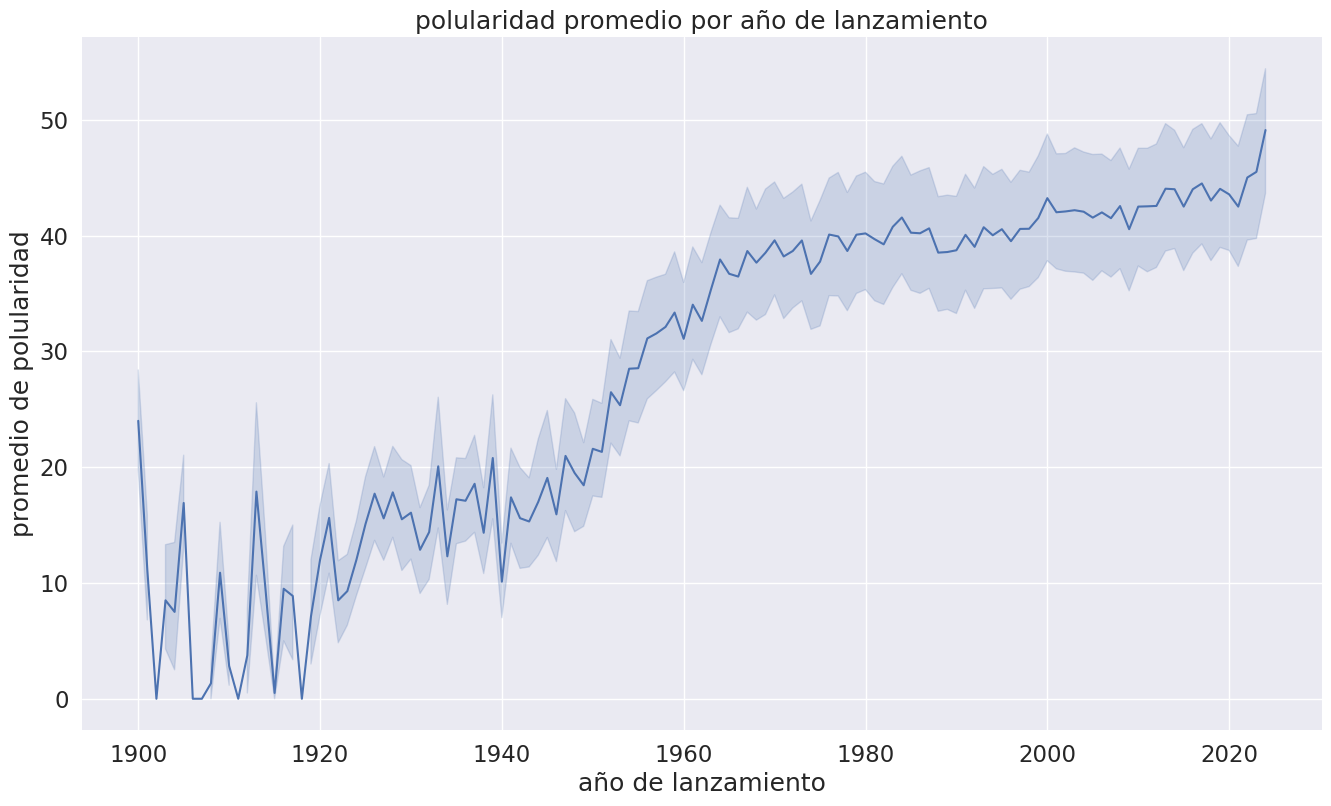

In [96]:
data = df_0[['release_year','popularity']].drop_duplicates().copy()
sns.set(rc={'figure.figsize':(16,9)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)
sns.lineplot(data,x='release_year',y='popularity')
plt.xlabel('año de lanzamiento')
plt.ylabel('promedio de polularidad')
plt.title('polularidad promedio por año de lanzamiento')
# Get the current Axes object
ax = plt.gca()

# Quitar las espinas (bordes) del gráfico using the Axes object
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Quitar las marcas de los ejes
plt.tick_params(top=False, bottom=False, left=False, right=False)

Artista más popular del año

In [108]:
data = df_0[['release_year','popularity','artista']].drop_duplicates().reset_index(drop=True).copy()
# Agrupar por año y calcular la popularidad promedio por artista
df_grouped = data.groupby(['release_year', 'artista'])['popularity'].mean().reset_index()
# Encontrar el artista más popular por año
df_max_popularity = df_grouped.groupby('release_year')['popularity'].idxmax()
df_result = df_grouped.loc[df_max_popularity]
# Mostrar el resultado
df_result.head(100)

,release_year,artista,popularity
54,1900,Lisandro Meza,45.000000
134,1901,Khin Maung Htoo,33.000000
142,1902,Enrico Caruso,0.000000
144,1903,Enrico Caruso,9.444444
147,1904,John McCormack,7.500000
...,...,...,...
26015,1995,"Coolio, L.V.",85.000000
27166,1996,"2Pac, Big Syke",76.000000
29452,1997,Natalie Imbruglia,80.000000
30028,1998,"2Pac, Outlawz",79.000000


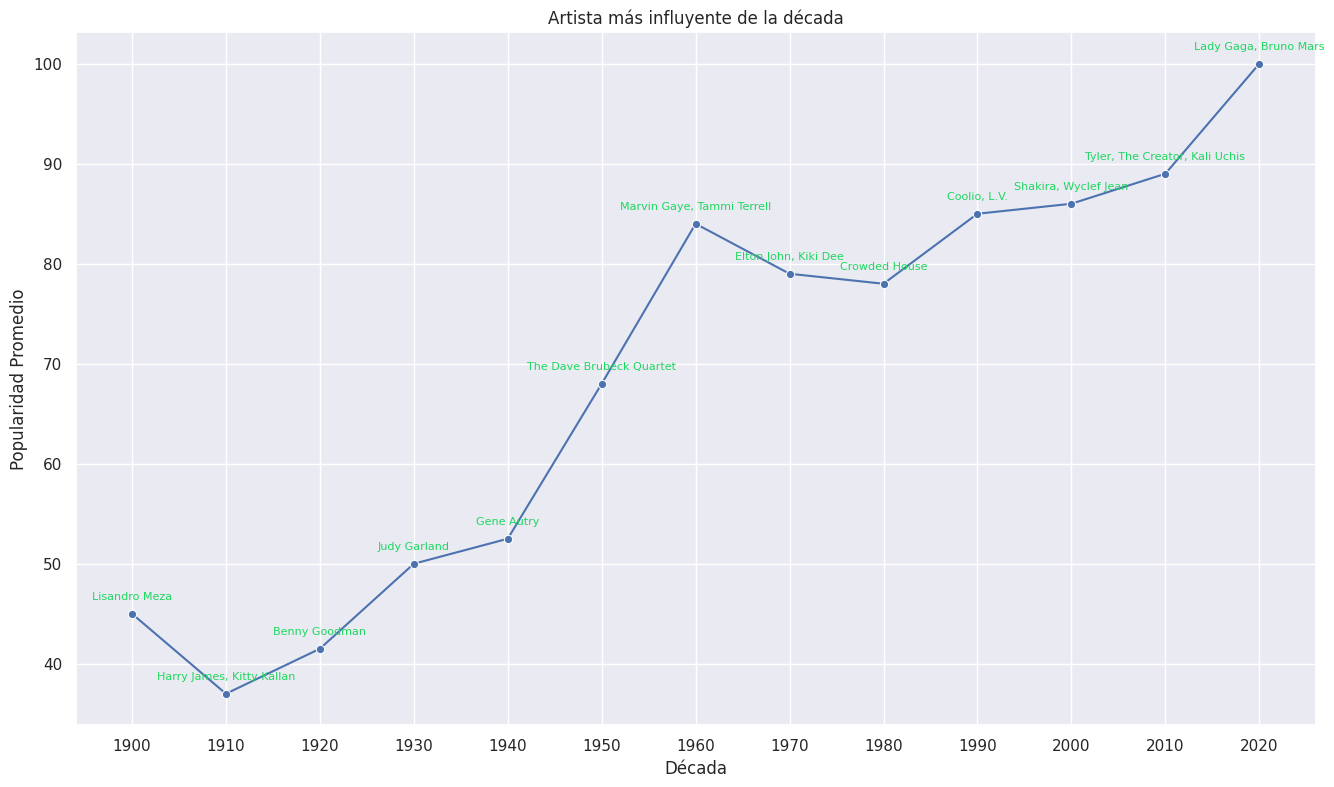

In [124]:
# Crear una nueva columna 'decade' basada en el año de lanzamiento
 # Agrupar por año y artista, calcular la popularidad promedio
data= df_0[['release_year','popularity','artista']].drop_duplicates().reset_index(drop=True).copy()
data['decade'] = data['release_year'] // 10 * 10

# Agrupar por década y artista, calcular la popularidad promedio
# Changed 'df' to 'df_grouped' to group by 'decade'
data = data.groupby(['decade', 'artista'])['popularity'].mean().reset_index()

# Encontrar el artista más popular por década
df_max_popularity = data.groupby('decade')['popularity'].idxmax()
df_result = data.loc[df_max_popularity]

# Crear el gráfico de líneas
sns.lineplot(x='decade', y='popularity', data=df_result, marker='o')

# Agregar etiquetas con el nombre del artista y la década
for x, y, label in zip(df_result['decade'], df_result['popularity'], df_result['artista']):
    plt.annotate(label, xy=(x, y), textcoords="offset points", xytext=(0,10), ha='center', color='#1ED760', fontweight='light', fontsize=8)

plt.xlabel('Década')
plt.ylabel('Popularidad Promedio')
plt.title('Artista más influyente de la década')
plt.xticks(df_result['decade'])  # Asegurar que se muestren todas las décadas en el eje x
plt.show()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57390 entries, 0 to 57389
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artista                    57390 non-null  object 
 1   album                      57390 non-null  object 
 2   cancion                    57390 non-null  object 
 3   id_track                   57390 non-null  object 
 4   fecha_lanzamiento          57390 non-null  object 
 5   genero                     57390 non-null  object 
 6   duration_ms                57390 non-null  int64  
 7   explicit                   57390 non-null  bool   
 8   popularity                 57390 non-null  int64  
 9   disc_number                57390 non-null  int64  
 10  track_number               57390 non-null  int64  
 11  duration_sec               57390 non-null  float64
 12  end_of_fade_in             57390 non-null  float64
 13  start_of_fade_out          57390 non-null  flo

In [25]:
# recuento de tracks unicos.
df['id_track'].nunique()

33592

Estimando que en la creación del dataset un mismo track puede pertenecer a más de un género y por eso el recuento de id_track unicos es menor al total de registros no duplicados, generamos algunas visualizaciones para entender este fenómeno.

In [31]:
# Agrupar por id_track y concatenar los géneros
df_genre_grouped = df.groupby('id_track')['genero'].apply(lambda x: ', '.join(x)).reset_index()
# Contar las ocurrencias de cada combinación
genre_counts = df_genre_grouped['genero'].value_counts().reset_index(name='count')
# renombrar el campo 'genero' a 'combination'
genre_counts.rename(columns={'genero': 'combination'}, inplace=True)
genre_counts['count_elements'] = genre_counts['combination'].str.split(',').str.len()
genre_counts.columns = ['combination', 'count', 'count_elements'] #adjust column order
# Ordenar por cantidad de ocurrencias
genre_counts_filtered = genre_counts.sort_values('count', ascending=False)
genre_counts_filtered = genre_counts_filtered[genre_counts_filtered['count_elements'] > 1].reset_index(drop=True)
genre_counts_filtered.head(10)

,combination,count,count_elements
0,"dub, dubstep",168,2
1,"singer-songwriter, songwriter",134,2
2,"dancehall, j-dance",133,2
3,"kids, party",99,2
4,"rock-n-roll, rockabilly",96,2
5,"latin, latino, reggae, reggaeton",89,4
6,"british, soul",87,2
7,"acoustic, guitar",80,2
8,"latino, reggaeton",74,2
9,"mpb, samba",70,2


In [32]:
genre_counts_filtered.to_csv('genre_counts_filtered.csv', index=False)

In [ ]:
# Agrupar por id_track y aplica una función que convierta los géneros asociados a cada id_track en una lista o conjunto.
# Contar el número de géneros por cada id_track y filtra aquellos con más de 3 géneros.
df_grouped = df.groupby('id_track')['genero'].apply(set).reset_index(name='generos')
df_filtered = df_grouped[df_grouped['generos'].apply(len) > 3]

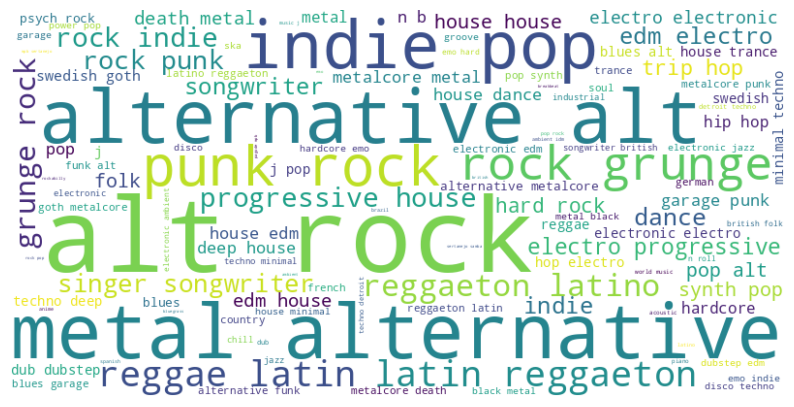

In [ ]:
# Crear una lista de todas las combinaciones de géneros
all_genres = []
for genres in df_filtered['generos']:
    all_genres.extend(list(genres))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_genres))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Se evidencia que las combinaciones pueden ser muy variadas. Por esto se porpone una visualización con los casos de mayor disgregación.

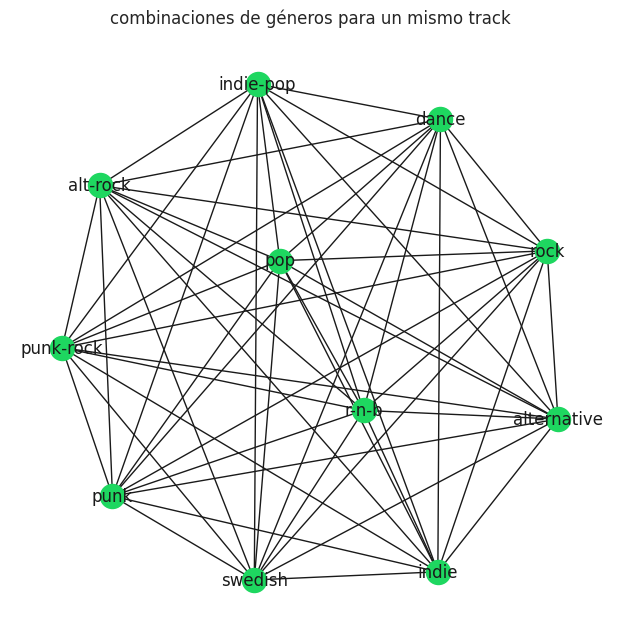

In [146]:
# Agrupar por id_track y contar géneros
grouped = df.groupby('id_track')['genero'].apply(list).reset_index()
filtered = grouped[grouped['genero'].apply(len) > 10]

node_color = '#1ED760'

# Crear el grafo
G = nx.Graph()
# Agregar nodos y aristas
for _, row in filtered.iterrows():
    genres = row['genero']
    for i in range(len(genres)):
        for j in range(i+1, len(genres)):
            G.add_edge(genres[i], genres[j], weight=1)  # Puedes ajustar el peso

# Visualización
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G)  # Puedes probar otros layouts
nx.draw(G, pos, with_labels=True, font_weight='light',node_color=node_color)
edge_labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
plt.title('combinaciones de géneros para un mismo track')
plt.show()

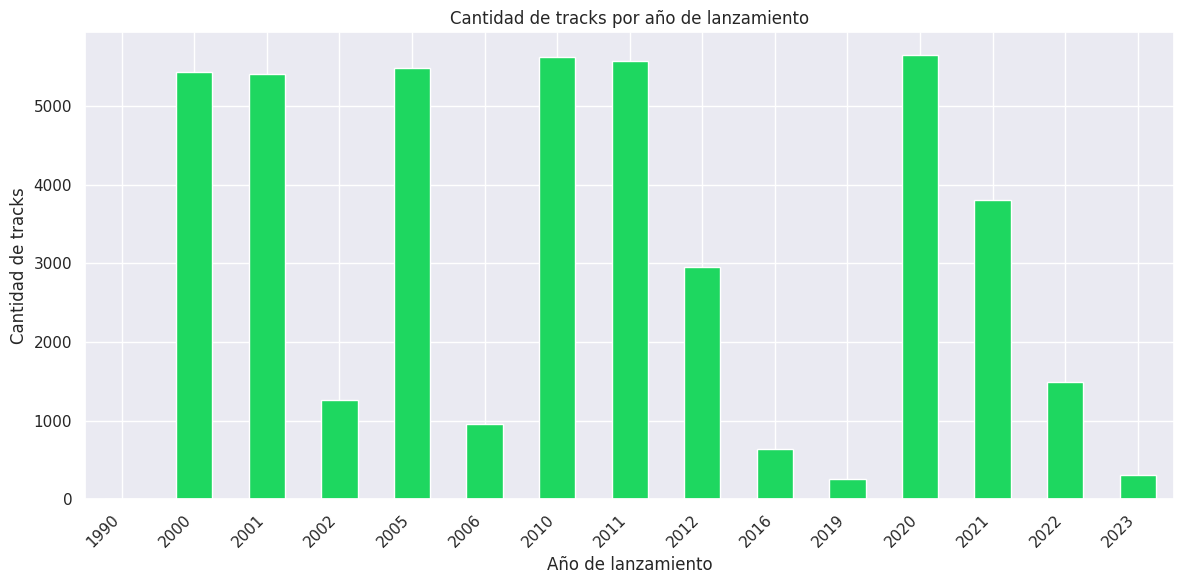

In [129]:
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
df['release_year'].value_counts().sort_index().plot(kind='bar',color='#1ED760')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Cantidad de tracks')
plt.title('Cantidad de tracks por año de lanzamiento')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

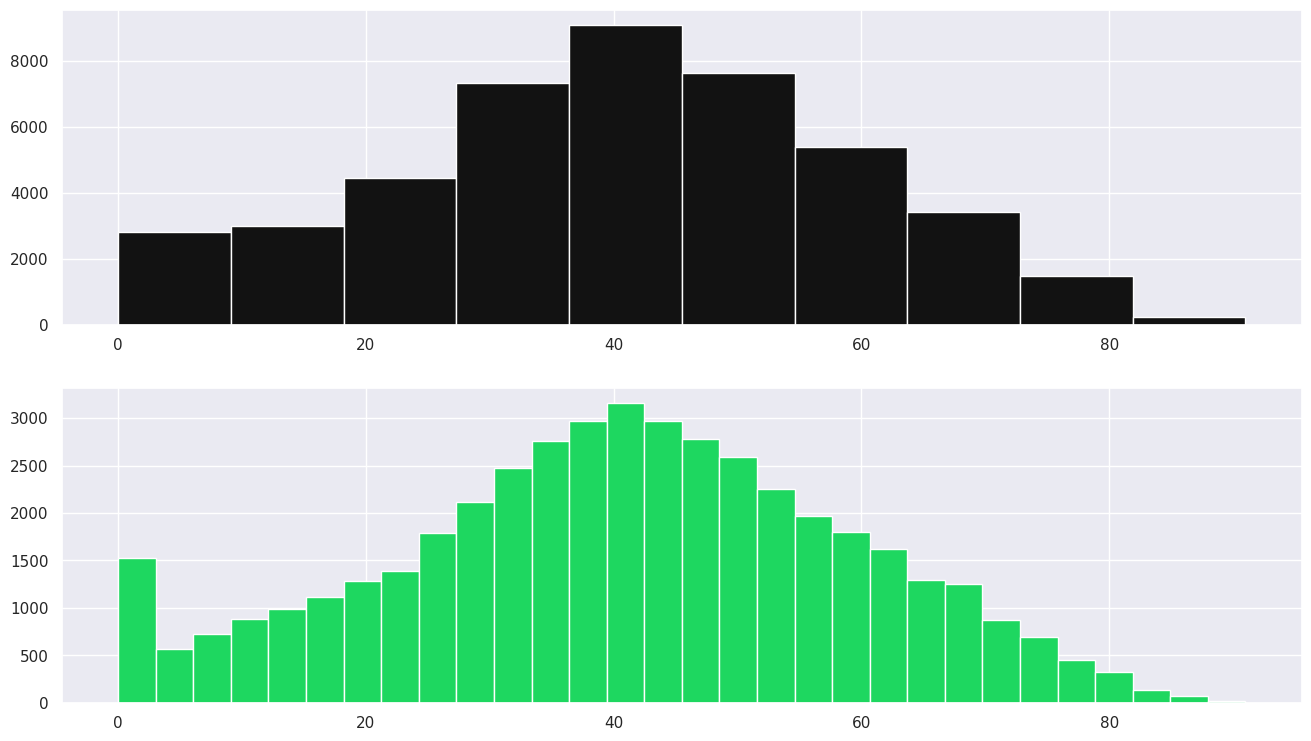

In [131]:
plt.subplot(2,1,1)
plt.hist(df.popularity, color= "#121212")
plt.subplot(2,1,2)
plt.hist(df.popularity,bins=30,color='#1ED760');

<ipython-input-147-74e7eb08d000>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  distplot(df.popularity, hist=True)


<Axes: xlabel='popularity', ylabel='Density'>

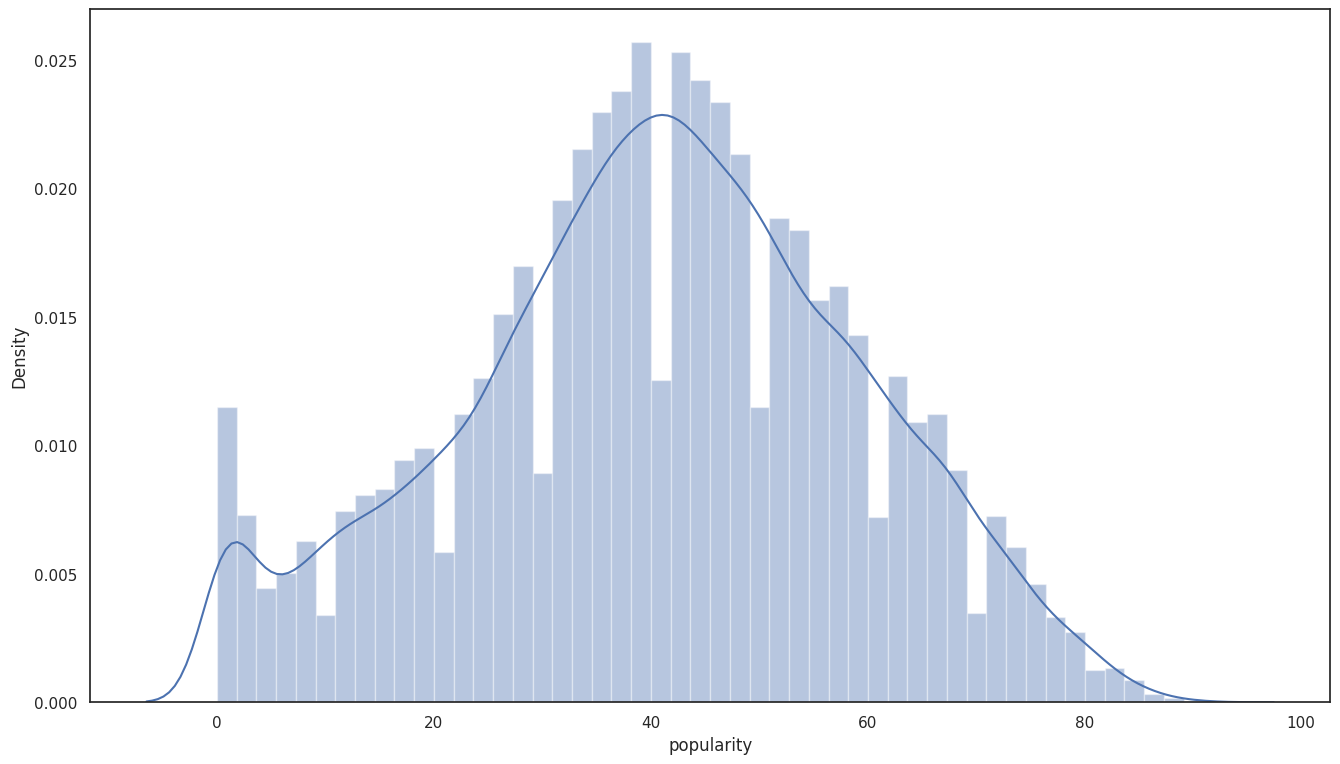

In [147]:
#Histograma
from seaborn import distplot
distplot(df.popularity, hist=True)

Buscar sesgos en la populadidad debido a  categorías variables propias del proceso de composición

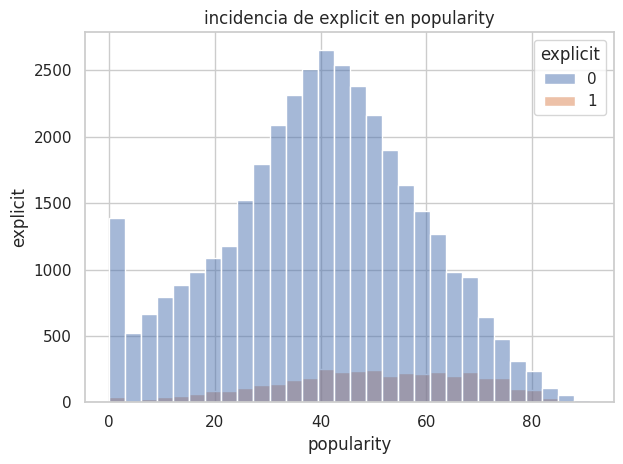

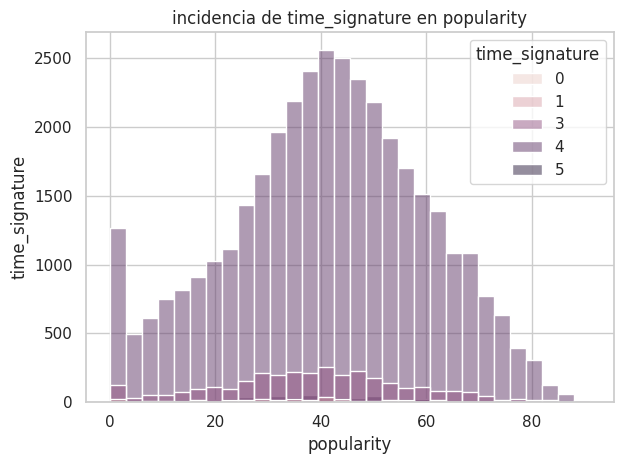

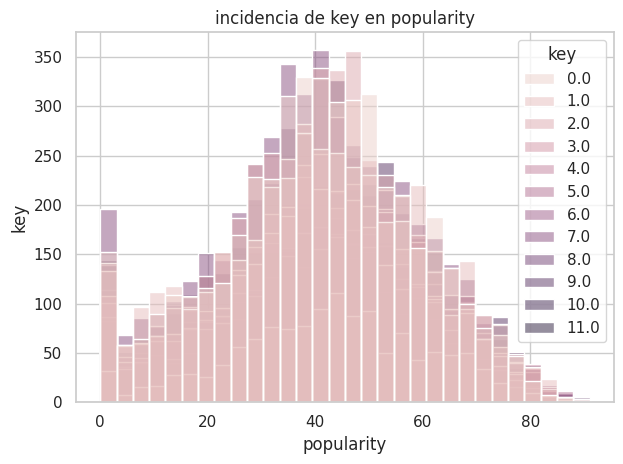

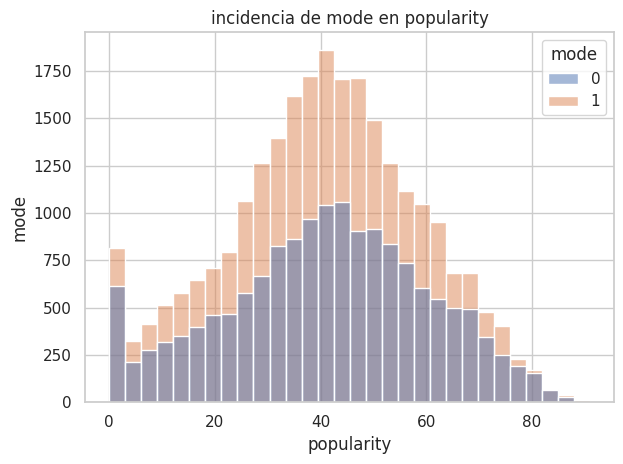

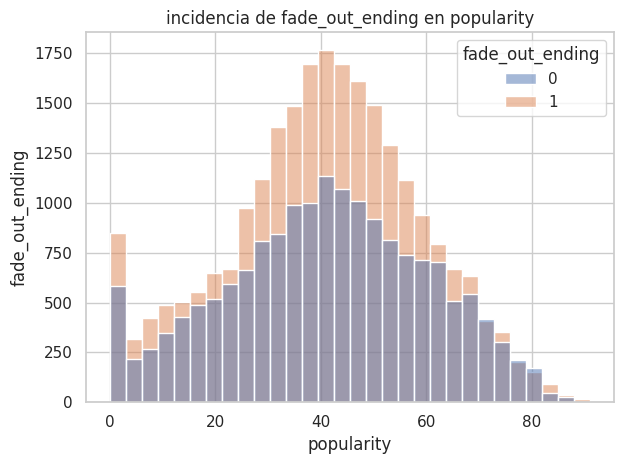

In [ ]:
categorias_formales= ['explicit', 'time_signature', 'key', 'mode','fade_out_ending']
sns.set_style("whitegrid")
# sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
for col in categorias_formales:
  plt.title(f'incidencia de {col} en popularity')
  plt.xlabel('popularity')
  plt.ylabel(col)
  sns.histplot(df,x='popularity',hue=col ,bins=30)
  plt.tight_layout()
  plt.show()

In [133]:
df.columns

Index(['artista', 'album', 'cancion', 'id_track', 'fecha_lanzamiento',
       'genero', 'duration_ms', 'explicit', 'popularity', 'disc_number',
       'track_number', 'duration_sec', 'end_of_fade_in', 'start_of_fade_out',
       'loudness', 'tempo', 'tempo_confidence', 'time_signature',
       'time_signature_confidence', 'key', 'key_confidence', 'mode',
       'mode_confidence', 'bars', 'beats', 'sections', 'segments', 'tatums',
       'release_year', 'fade_out_length_sec', 'bar_length_sec',
       'fade_out_length_bars', 'fade_out_ending'],
      dtype='object')

In [134]:
numerical_cols = ['popularity', 'disc_number','track_number', 'duration_sec',
                  'end_of_fade_in', 'start_of_fade_out','loudness', 'tempo', 'tempo_confidence',
                  'time_signature_confidence', 'key_confidence','mode_confidence',
                  'bars', 'beats', 'sections', 'segments', 'tatums',
                  'fade_out_length_sec', 'bar_length_sec','fade_out_length_bars']
numerical_df = df[numerical_cols]

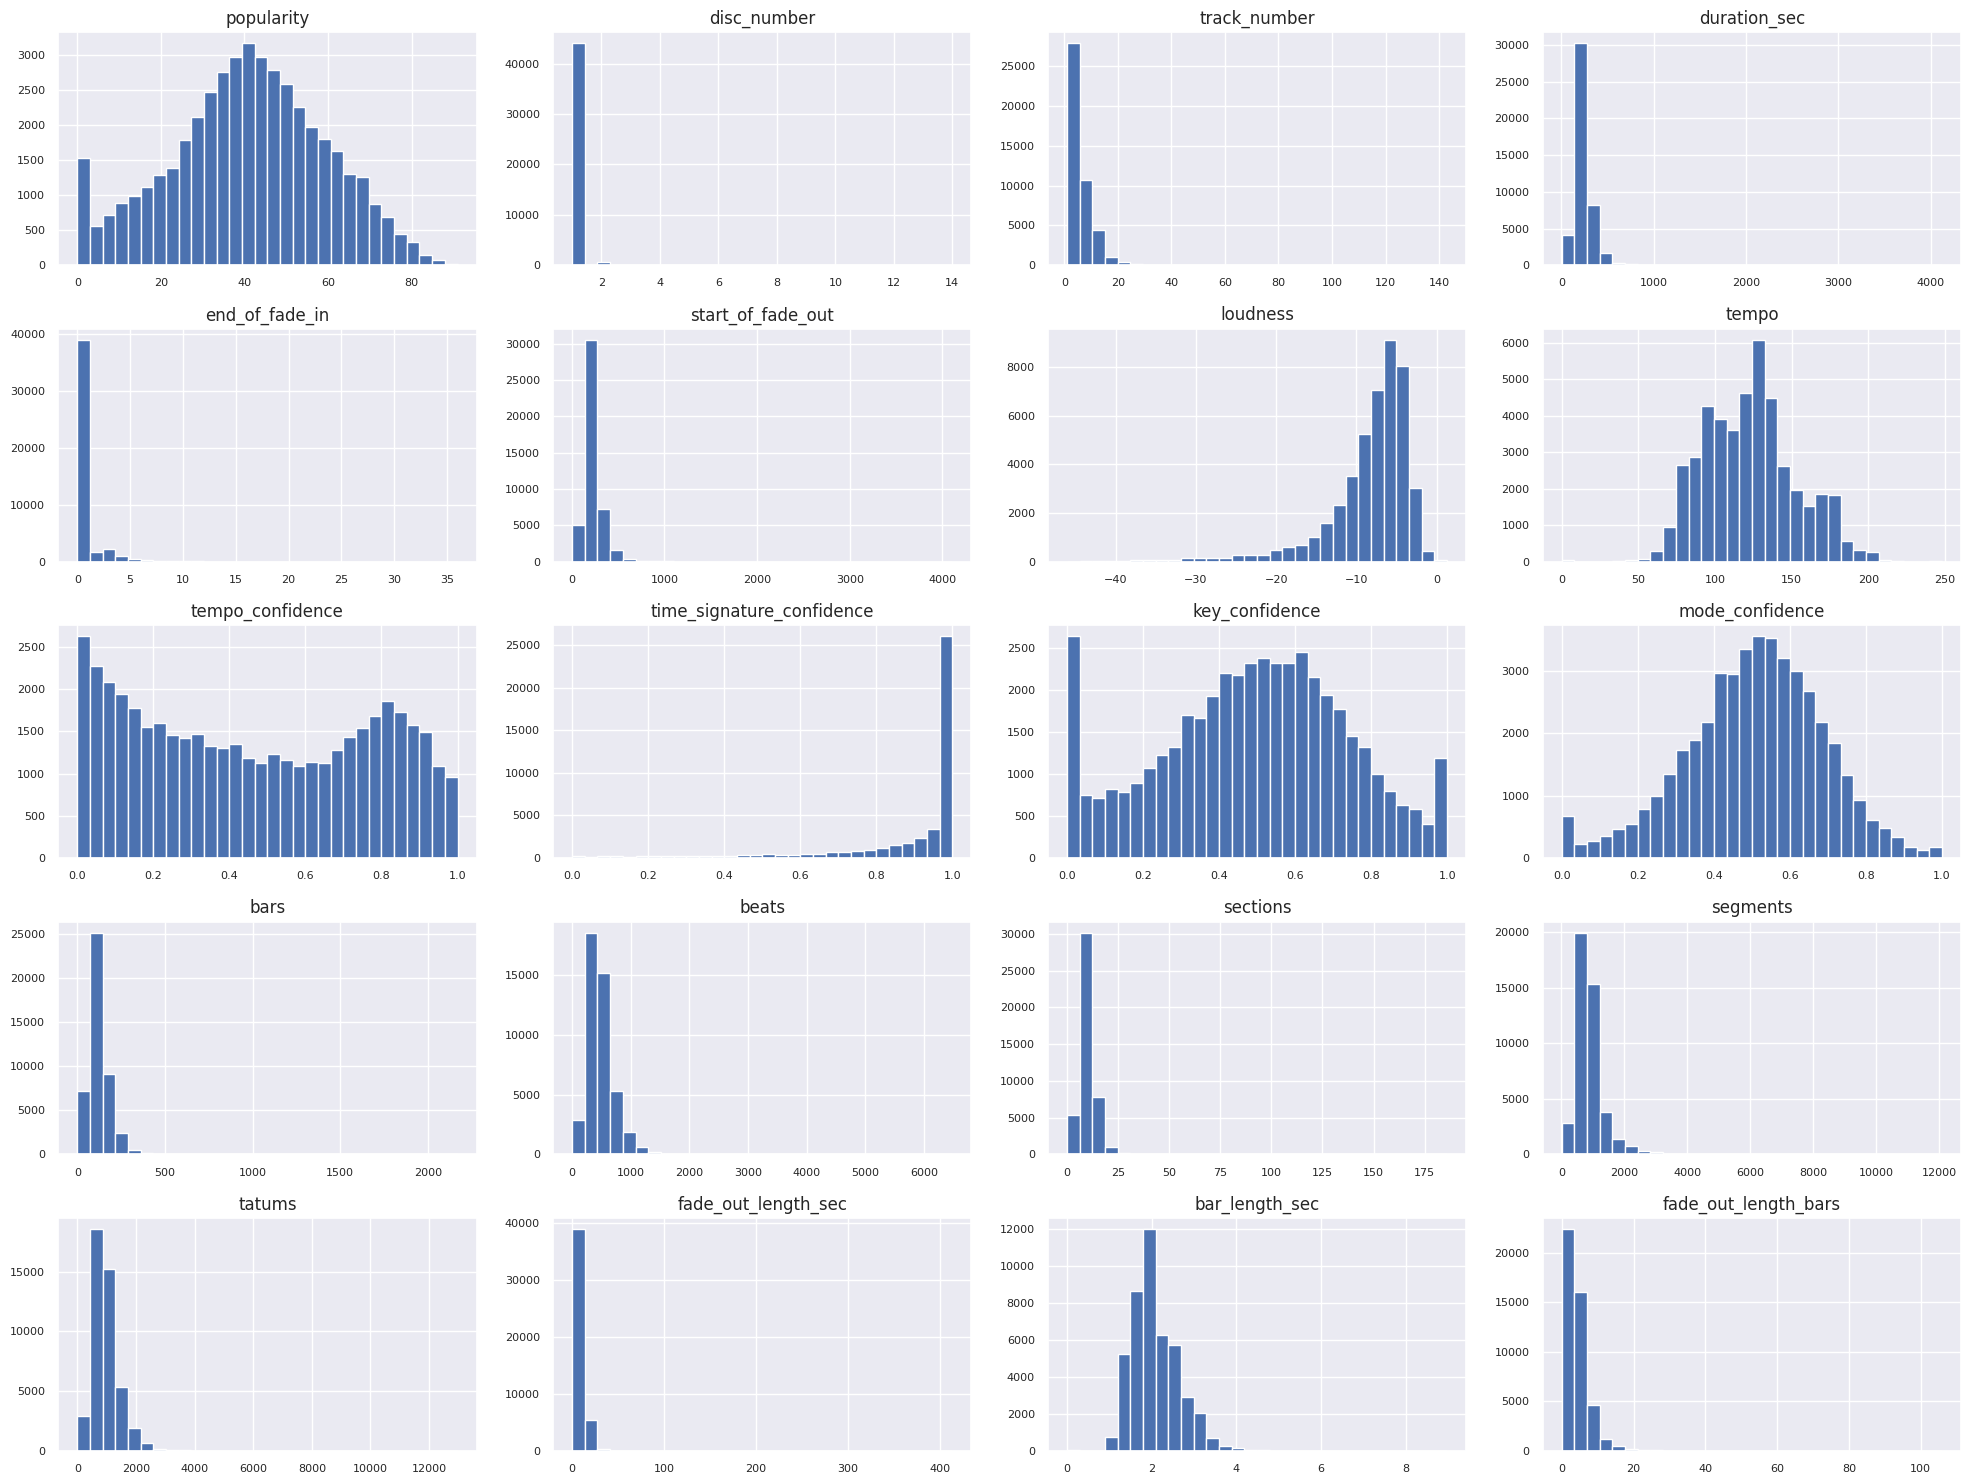

In [135]:
sns.set_style('darkgrid')
#sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
numerical_df.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()

### Outliers

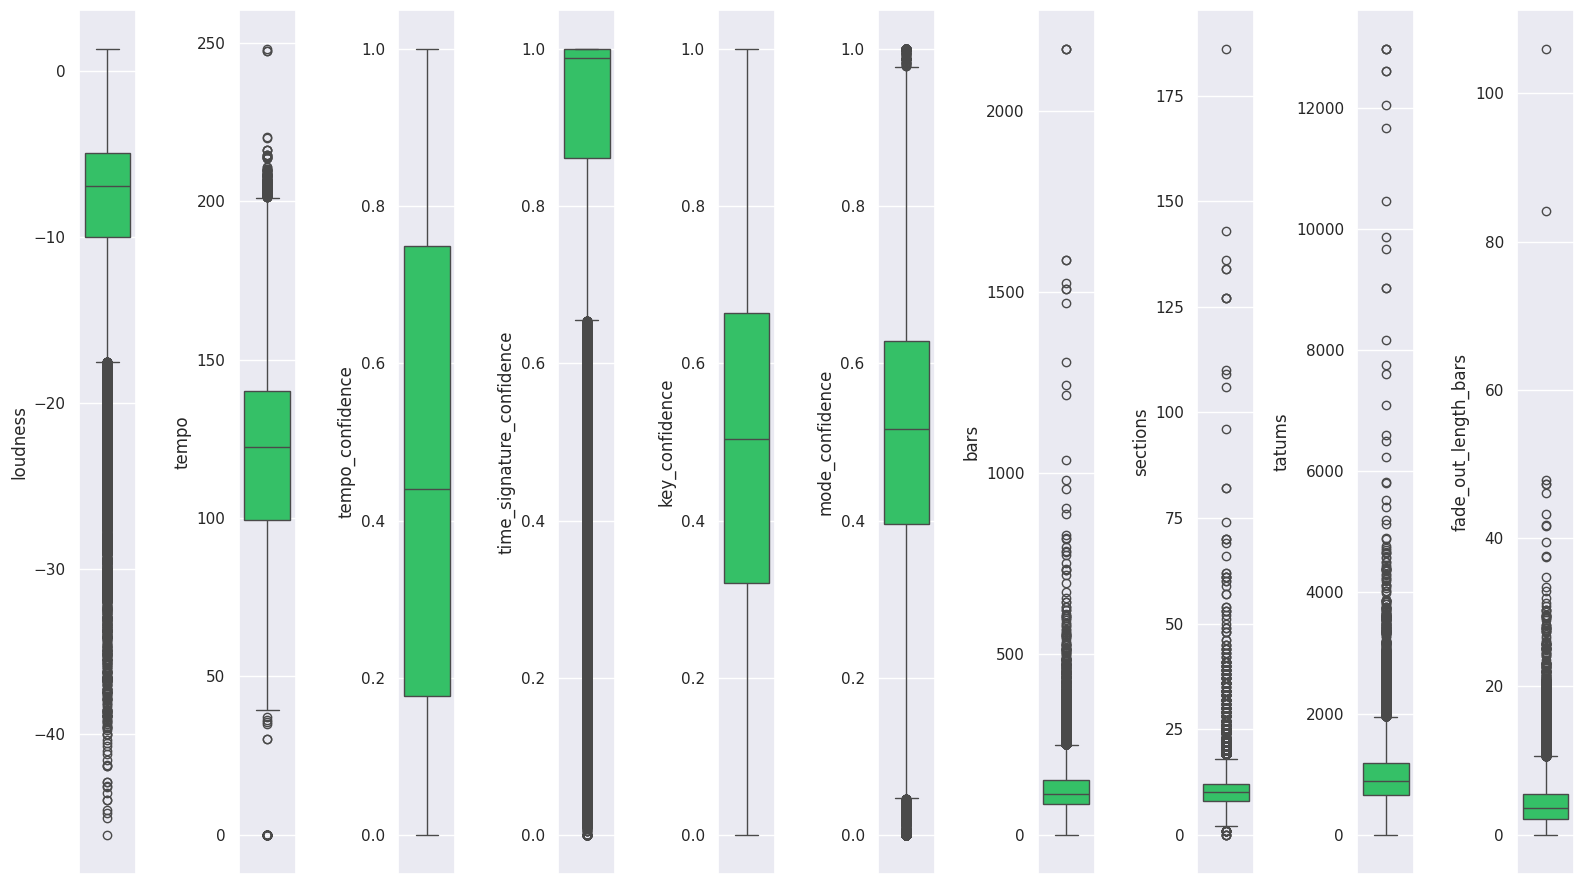

In [154]:
variables = [
            'loudness', 'tempo', 'tempo_confidence',
            'time_signature_confidence', 'key_confidence','mode_confidence',
              'bars', 'sections', 'tatums',
             'fade_out_length_bars']
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, len(variables), figsize=(16,9))

for ax, variable in zip(axes, variables):
    ax = sns.boxplot( y=variable, data=df, ax=ax, color='#1ED760')
plt.tight_layout()

Se utiliza el **Metodo IQR** para limpiar el conjunto de datos de valores extremos.

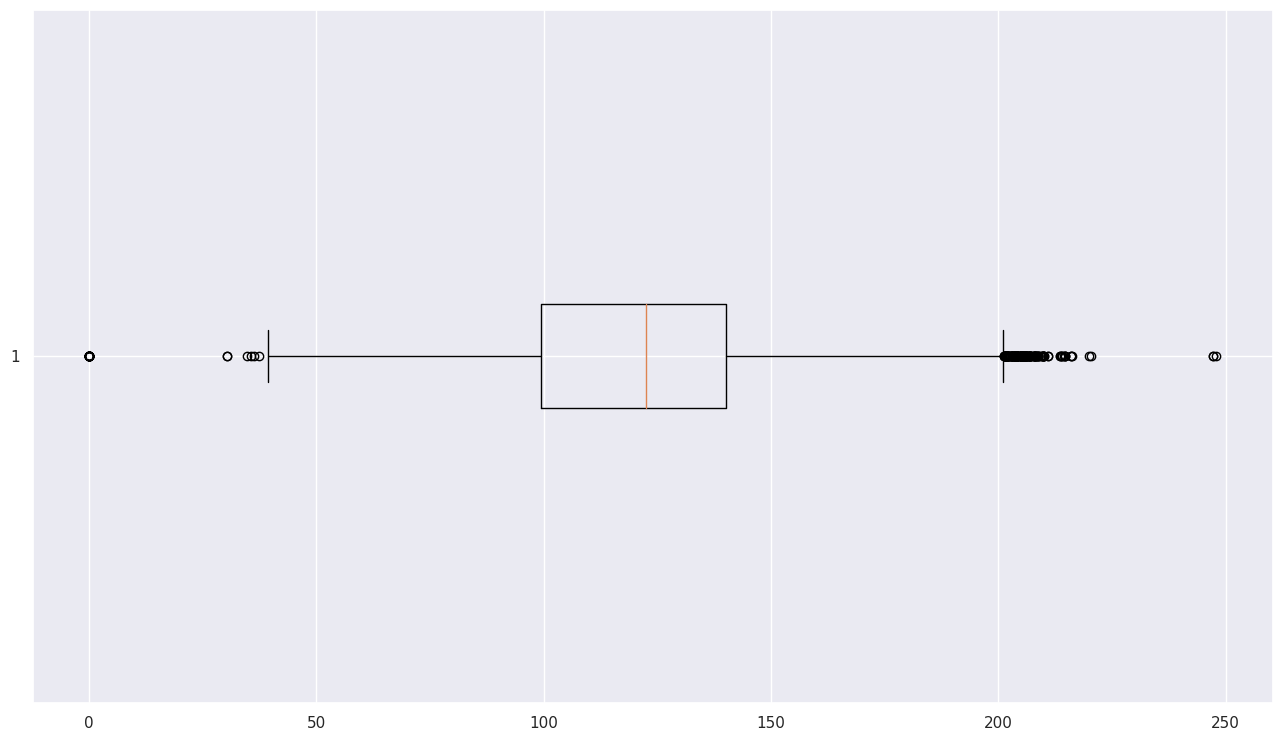

In [139]:
plt.boxplot(df.tempo,vert=False);

exploración simple:
*   tratamiento de valores duplicados
*   Nulos
*   Outliers con su respectiva justificación.  
*   Obtención de Insights preliminares





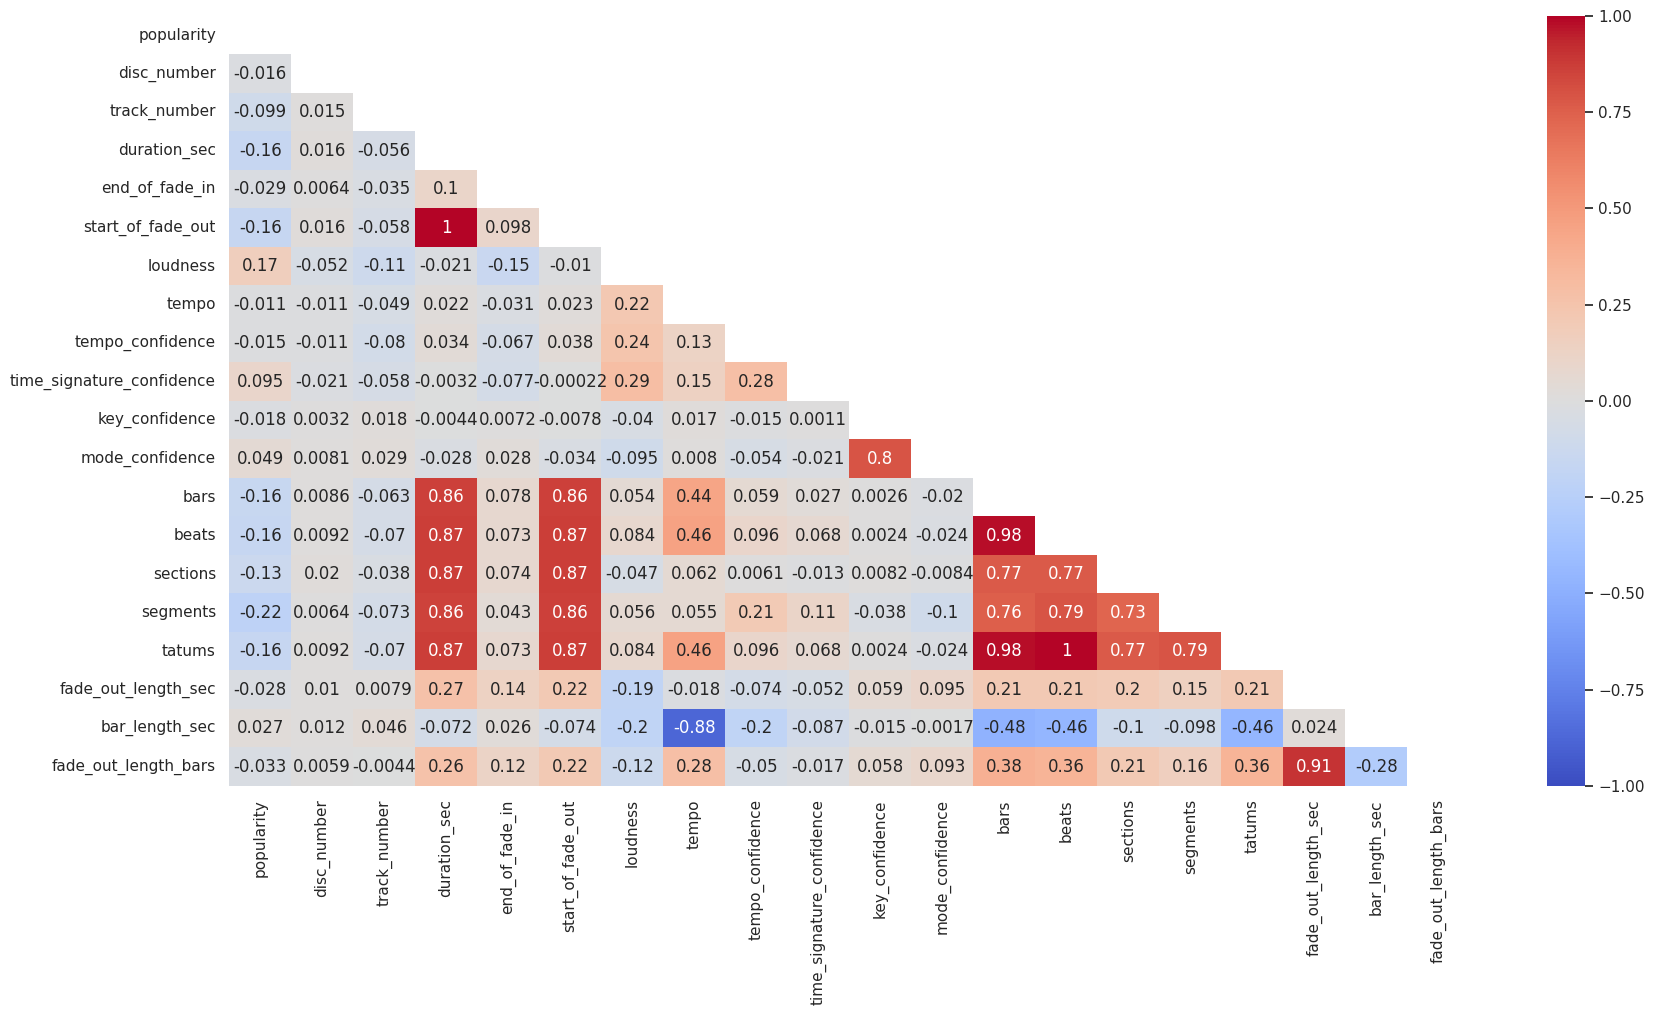

In [144]:
# heatmap for correlation
corr = numerical_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set_style('white')
#sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
plt.figure(figsize=(20, 10))
sns.heatmap(corr, mask=mask, annot=True, vmin=-1, vmax=1,cmap='coolwarm')
plt.show()

## Insights

1.   No se evidencia que existan aspectos formales de la composicion musical que afeten directamente al grado de polularidad alcanzado por una obra.

# Conclución

#Futuras líneas
Nuevas preguntas.

**Género musical:**
* ¿Las relaciones entre las variables y la popularidad varían según el género musical?
* ¿Existen características específicas que sean más importantes para ciertos géneros?

**Contexto cultural y temporal:**

* ¿Cómo han evolucionado las preferencias de los oyentes a lo largo del tiempo?
* ¿Existen diferencias culturales en las preferencias musicales?

**Análisis de letras:**
* ¿El contenido lírico influye en la popularidad?
* ¿Existen temas o estilos líricos que se asocien con mayor popularidad?
Análisis de artistas y productores:
* ¿Los artistas y productores más populares tienen un estilo característico?
* ¿La colaboración entre artistas influye en la popularidad de una canción?

**Análisis de redes sociales:**

* ¿Existe una correlación entre la actividad en redes sociales y la popularidad de una canción?
* ¿Los comentarios y las valoraciones de los usuarios pueden predecir la popularidad futura?